# Implement and train a LSTM for sentiment analysis

(General Hint on Lab 1/2: Trust whatever you see from the training and report it on PDF. IDMB is far from ideal as it's more like a real-world dataset)

## Step 0: set up the environment

In [1]:
pip install nltk

In [2]:
import functools
import sys
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import tqdm
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import collections
import re

nltk.download('stopwords')

torch.backends.cudnn.benchmark = True

import os
os.makedirs("resources", exist_ok=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Hyperparameters. Do not directly touch this to mess up settings.

If you want to initalize new hyperparameter sets, use "new_hparams = HyperParams()" and change corresponding fields.

In [3]:
class HyperParams:
    def __init__(self):
        # Constance hyperparameters. They have been tested and don't need to be tuned.
        self.PAD_INDEX = 0
        self.UNK_INDEX = 1
        self.PAD_TOKEN = '<pad>'
        self.UNK_TOKEN = '<unk>'
        self.STOP_WORDS = nltk.corpus.stopwords.words('english')
        self.MAX_LENGTH = 256
        self.BATCH_SIZE = 96
        self.EMBEDDING_DIM = 1
        self.HIDDEN_DIM = 100
        self.OUTPUT_DIM = 2
        self.N_LAYERS = 1
        self.DROPOUT_RATE = 0.0
        self.LR = 0.01
        self.N_EPOCHS = 5
        self.WD = 0
        self.OPTIM = "sgd"
        self.BIDIRECTIONAL = False
        self.SEED = 5

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Lab 1(a) Implement your own data loader function.  
First, you need to read the data from the dataset file on the local disk.
Then, split the dataset into three sets: train, validation and test by 7:1:2 ratio.
Finally return x_train, x_valid, x_test, y_train, y_valid, y_test where x represents reviews and y represent labels.  

In [5]:
stopwords = stopwords.words('english')

In [6]:
hparams = HyperParams()

In [7]:
def load_imdb(base_csv:str = '/content/drive/MyDrive/ECE 661 HW3/IMDBDataset.csv'):
    """
    Load the IMDB dataset
    :param base_csv: the path of the dataset file.
    :return: train, validation and test set.
    """
    # Add your code here.
    df=pd.read_csv(base_csv)


    x_train,x_test,y_train,y_test= train_test_split(df['review'],df['sentiment'], test_size=0.2,random_state=42)
    x_train,x_valid,y_train,y_valid =train_test_split(x_train,y_train,test_size=1/8,random_state=42)

    print(f'shape of train data is {x_train.shape}')
    print(f'shape of test data is {x_test.shape}')
    print(f'shape of valid data is {x_valid.shape}')
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [8]:
x_train,x_valid,x_test,y_train,y_valid,y_test=load_imdb()

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)


## Lab 1(b): Implement your function to build a vocabulary based on the training corpus.
You should first compute the frequency of all the words in the training corpus.
Use the given preprocess_string() function to process each word by "preprocess_string(word)".
Avoid the words that are in the STOP_WORDS.
Filter the words by their frequency (>=min_freq).
Generate a corpus variable which contains a list of words.  

In [9]:
def build_vocab(x_train:list, min_freq: int=5, hparams=None) -> dict:
    """
    build a vocabulary based on the training corpus.
    :param x_train:  List. The training corpus. Each sample in the list is a string of text.
    :param min_freq: Int. The frequency threshold for selecting words.
    :return: dictionary {word:index}
    """
    # Add your code here. Your code should assign corpus with a list of words.
    corpus = collections.defaultdict(int)
    hparams = HyperParams()
    top_words = hparams.STOP_WORDS


    for x in x_train:
      words =  re.findall('[a-zA-Z]+',re.sub(r'<.*?>', '', x))
      for word in words:
        if word not in top_words:
          corpus[word.lower()]+=1

    # sorting on the basis of most common words
    # corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    corpus_ = [word for word, freq in corpus.items() if freq >= min_freq]
    # creating a dict
    vocab = {w:i+2 for i, w in enumerate(corpus_)}
    vocab[hparams.PAD_TOKEN] = hparams.PAD_INDEX
    vocab[hparams.UNK_TOKEN] = hparams.UNK_INDEX
    return vocab


## Lab 1(c): Implement your tokenize function.
You should leverage the given preprocess_string() function to process each word by "preprocess_string(word)".
For each word, find its index in the vocabulary.
Return a list of int that represents the indices of words in the example.

In [10]:
def tokenize(vocab: dict, hparams, example: str) -> list:
    """
    Tokenize the given example string into a list of token indices.
    :param vocab: dict, the vocabulary.
    :param hparams: HyperParams object.
    :param example: a string of text.
    :return: a list of token indices.
    """
    words = re.findall('[a-zA-Z]+', re.sub(r'<.*?>', '', example))
    hparams = HyperParams()

    tokens = []
    for word in words:
      if word.lower() in vocab:
        tokens.append(vocab[word.lower()])
      elif word.lower() in stopwords:
        continue
      else:
        tokens.append(hparams.UNK_INDEX)

    return tokens


## Lab 1 (d): Implement the __getitem__ function. Given an index i, you should return the i-th review and label.
The review is originally a string. Please tokenize it into a sequence of token indices.
Use the max_length parameter to truncate the sequence so that it contains at most max_length tokens.
Convert the label string ('positive'/'negative') to a binary index. 'positive' is 1 and 'negative' is 0.
Return a dictionary containing three keys: 'ids', 'length', 'label' which represent the list of token ids, the length of the sequence, the binary label.

In [11]:
class IMDB(Dataset):
    def __init__(self, x, y, vocab, max_length=256) -> None:
        """
        :param x: list of reviews
        :param y: list of labels
        :param vocab: vocabulary dictionary {word:index}.
        :param max_length: the maximum sequence length.
        """
        self.x = x
        self.y = y
        self.vocab = vocab
        self.max_length = max_length

    def __getitem__(self, idx: int):
        """
        Return the tokenized review and label by the given index.
        :param idx: index of the sample.
        :return: a dictionary containing three keys: 'ids', 'length', 'label' which represent the list of token ids, the length of the sequence, the binary label.
        """
        text = self.x.iloc[idx]

        tokens = tokenize(vocab=self.vocab, hparams=hparams,example=text)[:self.max_length]
        label = 1 if self.y.iloc[idx] == 'positive' else 0


        return {
        'ids': tokens,
        'length': len(tokens),
        'label': label
         }


    def __len__(self) -> int:
        return len(self.x)

def collate(batch, pad_index):
    batch_ids = [torch.LongTensor(i['ids']) for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = torch.Tensor([i['length'] for i in batch])
    batch_label = torch.LongTensor([i['label'] for i in batch])
    #print(batch_label)
    batch = {'ids': batch_ids, 'length': batch_length, 'label': batch_label}
    return batch

collate_fn = collate

## Lab 1 (e): Implement the LSTM model for sentiment analysis.
Q(a): Implement the initialization function.
Your task is to create the model by stacking several necessary layers including an embedding layer, a lstm cell, a linear layer, and a dropout layer.
You can call functions from Pytorch's nn library. For example, nn.Embedding, nn.LSTM, nn.Linear.<br>
Q(b): Implement the forward function.
    Decide where to apply dropout.
    The sequences in the batch have different lengths. Write/call a function to pad the sequences into the same length.
    Apply a fully-connected (fc) layer to the output of the LSTM layer.
    Return the output features which is of size [batch size, output dim].

In [12]:
def init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.xavier_normal_(m.weight)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM) or isinstance(m, nn.GRU):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        output_dim: int,
        n_layers: int,
        dropout_rate: float,
        pad_index: int,
        bidirectional: bool,
        **kwargs):
        """
        Create a LSTM model for classification.
        :param vocab_size: size of the vocabulary
        :param embedding_dim: dimension of embeddings
        :param hidden_dim: dimension of hidden features
        :param output_dim: dimension of the output layer which equals to the number of labels.
        :param n_layers: number of layers.
        :param dropout_rate: dropout rate.
        :param pad_index: index of the padding token
        """
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.
        hparams = HyperParams()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout= dropout_rate, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim *hparams.MAX_LENGTH* 2 if bidirectional else hidden_dim * hparams.MAX_LENGTH, output_dim)

        # Weight initialization. DO NOT CHANGE!
        if "weight_init_fn" not in kwargs:
            self.apply(init_weights)
        else:
            self.apply(kwargs["weight_init_fn"])

    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        """
        Feed the given token ids to the model.
        :param ids: [batch size, seq len] batch of token ids.
        :param length: [batch size] batch of length of the token ids.
        :return: prediction of size [batch size, output dim].
        """
        # Add your code here.
        out = self.embedding(ids)
        out=self.dropout(out)
        out  = nn.utils.rnn.pack_padded_sequence(out, length, batch_first=True, enforce_sorted=False)
        out, _ = self.lstm(out)
        unpacked_out, unpacked_lengths = nn.utils.rnn.pad_packed_sequence(out, batch_first=True,total_length=256)
        out = unpacked_out.view( unpacked_out.shape[0], -1)
        out=self.dropout(out)
        out = self.fc(out)

        return out

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(dataloader, model, criterion, optimizer, scheduler, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        scheduler.step()

    return epoch_losses, epoch_accs

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def predict_sentiment(text, model, vocab, device, hparams = HyperParams()):
    tokens = tokenize(vocab, text)
    ids = [vocab[t] if t in vocab else hparams.UNK_INDEX for t in tokens]
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

### Lab 1 (g) Implement GRU.

In [14]:
class GRU(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        output_dim: int,
        n_layers: int,
        dropout_rate: float,
        pad_index: int,
        bidirectional: bool,
        **kwargs):
        """
        Create a LSTM model for classification.
        :param vocab_size: size of the vocabulary
        :param embedding_dim: dimension of embeddings
        :param hidden_dim: dimension of hidden features
        :param output_dim: dimension of the output layer which equals to the number of labels.
        :param n_layers: number of layers.
        :param dropout_rate: dropout rate.
        :param pad_index: index of the padding token.we
        """
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.
        self.max_length = kwargs['max_length']
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout= dropout_rate, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim *self.max_length* 2 if bidirectional else hidden_dim * self.max_length, output_dim)

        # Weight Initialization. DO NOT CHANGE!
        if "weight_init_fn" not in kwargs:
            self.apply(init_weights)
        else:
            self.apply(kwargs["weight_init_fn"])

    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        """
        Feed the given token ids to the model.
        :param ids: [batch size, seq len] batch of token ids.
        :param length: [batch size] batch of length of the token ids.
        :return: prediction of size [batch size, output dim].
        """
        # Add your code here.
        out = self.embedding(ids)
        out=self.dropout(out)
        out  = nn.utils.rnn.pack_padded_sequence(out, length, batch_first=True, enforce_sorted=False)
        out, _ = self.gru(out)
        unpacked_out, unpacked_lengths = nn.utils.rnn.pad_packed_sequence(out, batch_first=True, total_length = self.max_length)
        out = unpacked_out.view( unpacked_out.shape[0], -1)
        out=self.dropout(out)
        out = self.fc(out)

        return out

### Learning rate warmup. DO NOT TOUCH!

In [15]:
class ConstantWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self,
        optimizer,
        num_warmup_steps: int,
    ):
        self.num_warmup_steps = num_warmup_steps
        super().__init__(optimizer)

    def get_lr(self):
        if self._step_count <= self.num_warmup_steps:
            # warmup
            scale = 1.0 - (self.num_warmup_steps - self._step_count) / self.num_warmup_steps
            lr = [base_lr * scale for base_lr in self.base_lrs]
            self.last_lr = lr
        else:
            lr = self.base_lrs
        return lr

### Implement the training / validation iteration here.

In [16]:
def train_and_test_model_with_hparams(hparams, model_type="lstm", **kwargs):
    # Seeding. DO NOT TOUCH! DO NOT TOUCH hparams.SEED!
    # Set the random seeds.
    torch.manual_seed(hparams.SEED)
    random.seed(hparams.SEED)
    np.random.seed(hparams.SEED)

    CHECKPOINT_FOLDER = '/content/drive/MyDrive/ECE 661 HW3/models/'
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()
    vocab = build_vocab(x_train, hparams=hparams)
    vocab_size = len(vocab)
    print(f'Length of vocabulary is {vocab_size}')

    train_data = IMDB(x_train, y_train, vocab, hparams.MAX_LENGTH)
    valid_data = IMDB(x_valid, y_valid, vocab, hparams.MAX_LENGTH)
    test_data = IMDB(x_test, y_test, vocab, hparams.MAX_LENGTH)

    collate = functools.partial(collate_fn, pad_index=hparams.PAD_INDEX)

    train_dataloader = torch.utils.data.DataLoader(
        train_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(
        valid_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate)
    test_dataloader = torch.utils.data.DataLoader(
        test_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate)


    # Model
    if "override_models_with_gru" in kwargs and kwargs["override_models_with_gru"]:
        model = GRU(
            vocab_size,
            hparams.EMBEDDING_DIM,
            hparams.HIDDEN_DIM,
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE,
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            max_length = hparams.MAX_LENGTH,
            **kwargs)
    else:
        model = LSTM(
            vocab_size,
            hparams.EMBEDDING_DIM,
            hparams.HIDDEN_DIM,
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE,
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            max_length = hparams.MAX_LENGTH,
            **kwargs)
    num_params = count_parameters(model)
    print(f'The model has {num_params:,} trainable parameters')


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Optimization. Lab 2 (a)(b) should choose one of them.
    # DO NOT TOUCH optimizer-specific hyperparameters! (e.g., eps, momentum)
    # DO NOT change optimizer implementations!
    if hparams.OPTIM == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, momentum=.9)
    elif hparams.OPTIM == "adagrad":
        print("Using adagrad")
        optimizer = optim.Adagrad(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "adam":
        optimizer = optim.Adam(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "rmsprop":
        print("Using rmsprop")
        optimizer = optim.RMSprop(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6, momentum=.9)
    else:
        raise NotImplementedError("Optimizer not implemented!")

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    # Start training
    best_valid_loss = float('inf')
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    # Warmup Scheduler. DO NOT TOUCH!
    WARMUP_STEPS = 200
    lr_scheduler = ConstantWithWarmup(optimizer, WARMUP_STEPS)

    for epoch in range(hparams.N_EPOCHS):

        # Your code: implement the training process and save the best model.

        (train_loss, train_acc), (valid_loss, valid_acc) = (train(train_dataloader, model, criterion, optimizer, lr_scheduler, device),
                                                        evaluate(valid_dataloader, model, criterion, device))

        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)
        epoch_valid_loss = np.mean(valid_loss)
        epoch_valid_acc = np.mean(valid_acc)

        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        valid_losses.append(epoch_valid_loss)
        valid_accs.append(epoch_valid_acc)


        # Save the model that achieves the smallest validation loss.

        if epoch_valid_loss < best_valid_loss:
            # Your code: save the best model somewhere (no need to submit it to Sakai)
            best_valid_loss = epoch_valid_loss
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            print("Saving ...")
            state = {'state_dict': model.state_dict(),
                   'epoch': epoch}
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_FOLDER, f'{model_type}.pth'))



        print(f'epoch: {epoch+1}')
        print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
        print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

    # Your Code: Load the best model's weights.
    if "override_models_with_gru" in kwargs and kwargs["override_models_with_gru"]:
        model = GRU(
            vocab_size,
            hparams.EMBEDDING_DIM,
            hparams.HIDDEN_DIM,
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE,
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            max_length = hparams.MAX_LENGTH,
            **kwargs)

    else:
        model = LSTM(
            vocab_size,
            hparams.EMBEDDING_DIM,
            hparams.HIDDEN_DIM,
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE,
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            max_length = hparams.MAX_LENGTH,
            **kwargs)
    state_dict = torch.load(os.path.join(CHECKPOINT_FOLDER, f'/content/drive/MyDrive/ECE 661 HW3/models/{model_type}.pth'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.load_state_dict(state_dict)

    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)


# Your Code: Evaluate test loss on the testing dataset (NOT Validation)
    model.eval()
    test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

    epoch_test_loss = np.mean(test_loss)

    epoch_test_acc = np.mean(test_acc)
    print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

    # Free memory for later usage.
    del model
    torch.cuda.empty_cache()
    return {
        'num_params': num_params,
        "test_loss": epoch_test_loss,
        "test_acc": epoch_test_acc,
        'train_loss': train_losses,
        'train_acc': train_accs,
        'valid_loss': valid_losses,
        'valid_acc': valid_accs,
    }

### Lab 1 (f): Train model with original hyperparameters, for LSTM.

Train the model with default hyperparameter settings.

In [36]:
org_hyperparams = HyperParams()
vanilla_lstm = train_and_test_model_with_hparams(org_hyperparams, "lstm_1layer_base_sgd_e32_h100")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 125,975 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 26.80it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.505
valid_loss: 0.693, valid_acc: 0.511
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 25.64it/s]
epoch: 2
train_loss: 0.693, train_acc: 0.509
valid_loss: 0.693, valid_acc: 0.511
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 24.25it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.506
valid_loss: 0.692, valid_acc: 0.507
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 26.44it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.509
valid_loss: 0.692, valid_acc: 0.513
evaluating...: 100%|██████████| 53/53 [00:01<00:00, 26.71it/s]
epoch: 5
train_loss: 0.693, train_acc: 0.508
valid_loss: 0.693, valid_acc: 0.504
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 24.40it/s]
test_loss: 0.69

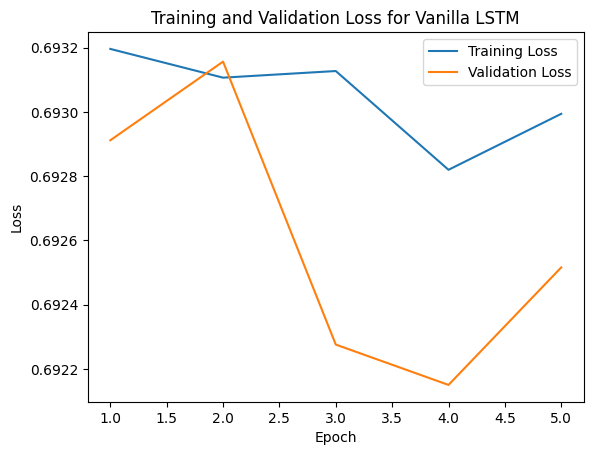

In [38]:
train_losses = vanilla_lstm['train_loss']
valid_losses = vanilla_lstm['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Vanilla LSTM')
plt.legend()
plt.show()

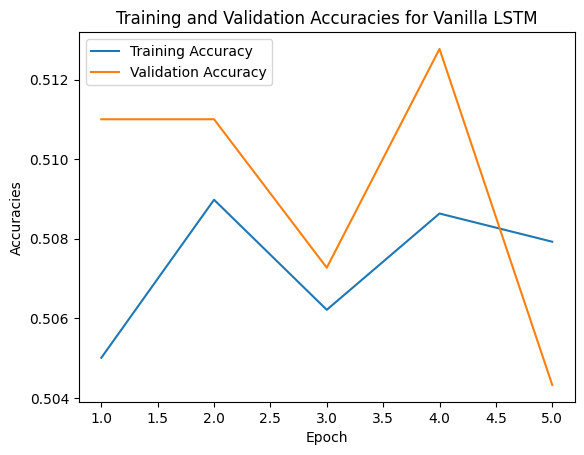

In [42]:
train_acc= vanilla_lstm['train_acc']
valid_acc = vanilla_lstm['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies for Vanilla LSTM')
plt.legend()
plt.show()

### Lag 1 (h) Train GRU with vanilla hyperparameters.

In [19]:
org_hyperparams = HyperParams()
vanilla_GRU= train_and_test_model_with_hparams(org_hyperparams, "gru_1layer_base_sgd_e32_h100", override_models_with_gru=True)

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 115,675 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.74it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.505
valid_loss: 0.693, valid_acc: 0.508
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.79it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.507
valid_loss: 0.693, valid_acc: 0.508
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.83it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.510
valid_loss: 0.692, valid_acc: 0.511
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 13.97it/s]
epoch: 4
train_loss: 0.693, train_acc: 0.507
valid_loss: 0.694, valid_acc: 0.509
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 17.67it/s]
epoch: 5
train_loss: 0.693, train_acc: 0.511
valid_loss: 0.692, valid_acc: 0.511
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 21.45it/s]
test_loss: 0.69

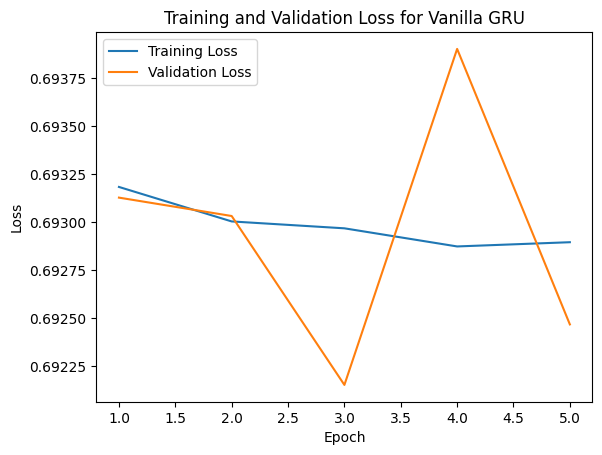

In [20]:
train_losses = vanilla_GRU['train_loss']
valid_losses = vanilla_GRU['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Vanilla GRU')
plt.legend()
plt.show()

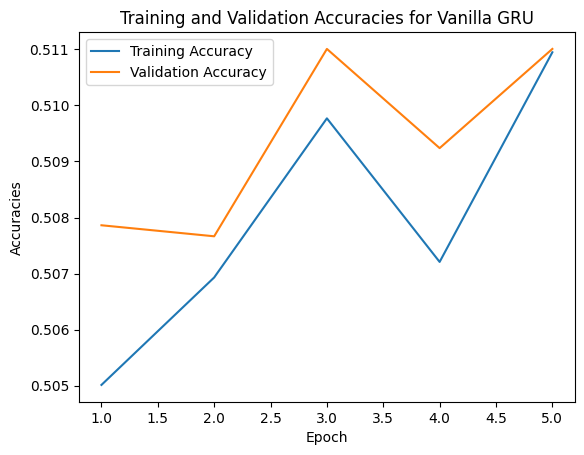

In [21]:
train_acc= vanilla_GRU['train_acc']
valid_acc = vanilla_GRU['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies for Vanilla GRU')
plt.legend()
plt.show()

### Lab 2 (a) Study of LSTM Optimizers. Hint: For adaptive optimizers, we recommend using a learning rate of 0.001 (instead of 0.01).

**Using Adagrad Optimizer**

In [22]:
adagrad_hyperparams = HyperParams()
adagrad_hyperparams.LR = 0.001
adagrad_hyperparams.OPTIM = "adagrad"

adagrad_optim_LSTM= train_and_test_model_with_hparams(adagrad_hyperparams, "lstm_1layer_base_adagrad_e32_h100")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 125,975 trainable parameters
Using adagrad
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.96it/s]
Saving ...
epoch: 1
train_loss: 0.691, train_acc: 0.521
valid_loss: 0.670, valid_acc: 0.642
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.76it/s]
Saving ...
epoch: 2
train_loss: 0.504, train_acc: 0.766
valid_loss: 0.473, valid_acc: 0.789
evaluating...: 100%|██████████| 53/53 [00:04<00:00, 12.16it/s]
Saving ...
epoch: 3
train_loss: 0.387, train_acc: 0.837
valid_loss: 0.419, valid_acc: 0.824
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 15.78it/s]
Saving ...
epoch: 4
train_loss: 0.346, train_acc: 0.858
valid_loss: 0.364, valid_acc: 0.848
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.96it/s]
Saving ...
epoch: 5
train_loss: 0.319, train_acc: 0.870
valid_loss: 0.356, valid_acc: 0.851
evaluating...: 100%|██████████| 105/105 [00:

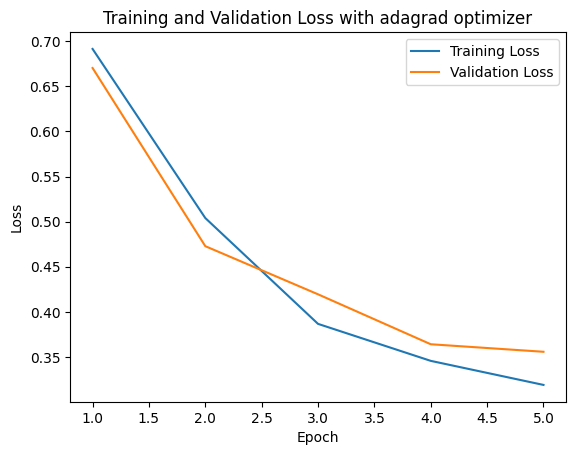

In [26]:
train_losses = adagrad_optim_LSTM['train_loss']
valid_losses = adagrad_optim_LSTM['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with adagrad optimizer')
plt.legend()
plt.show()

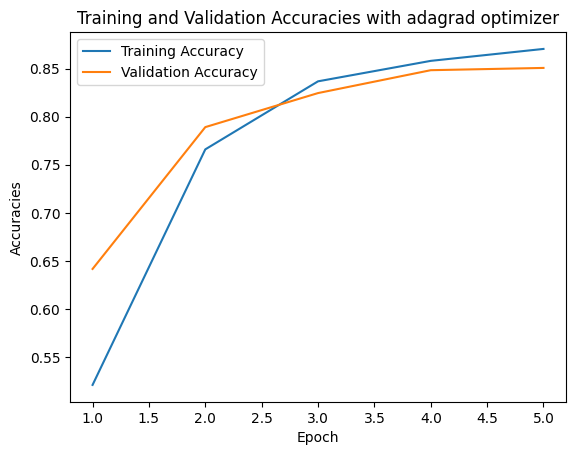

In [25]:
train_acc= adagrad_optim_LSTM['train_acc']
valid_acc = adagrad_optim_LSTM['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies with adagrad optimizer')
plt.legend()
plt.show()

**Using RMSProp Optimizer**

In [23]:
rms_hyperparams = HyperParams()
rms_hyperparams.LR = 0.001
rms_hyperparams.OPTIM = "rmsprop"
rms_optim_LSTM = train_and_test_model_with_hparams(rms_hyperparams, "lstm_1layer_base_rmsprop_e32_h100")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 125,975 trainable parameters
Using rmsprop
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.73it/s]
Saving ...
epoch: 1
train_loss: 0.414, train_acc: 0.792
valid_loss: 0.303, valid_acc: 0.878
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 14.56it/s]
epoch: 2
train_loss: 0.219, train_acc: 0.916
valid_loss: 0.354, valid_acc: 0.867
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.61it/s]
epoch: 3
train_loss: 0.153, train_acc: 0.942
valid_loss: 0.339, valid_acc: 0.867
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.70it/s]
epoch: 4
train_loss: 0.109, train_acc: 0.960
valid_loss: 0.411, valid_acc: 0.873
evaluating...: 100%|██████████| 53/53 [00:04<00:00, 11.82it/s]
epoch: 5
train_loss: 0.080, train_acc: 0.970
valid_loss: 0.484, valid_acc: 0.863
evaluating...: 100%|██████████| 105/105 [00:05<00:00, 18.51it/s]
test_loss: 0.292, test_

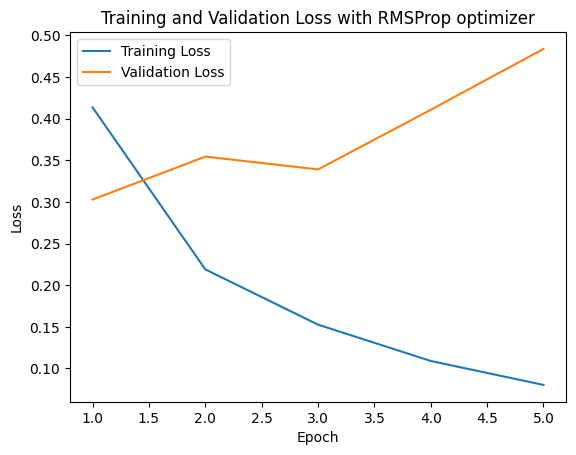

In [27]:
train_losses = rms_optim_LSTM['train_loss']
valid_losses = rms_optim_LSTM['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with RMSProp optimizer')
plt.legend()
plt.show()

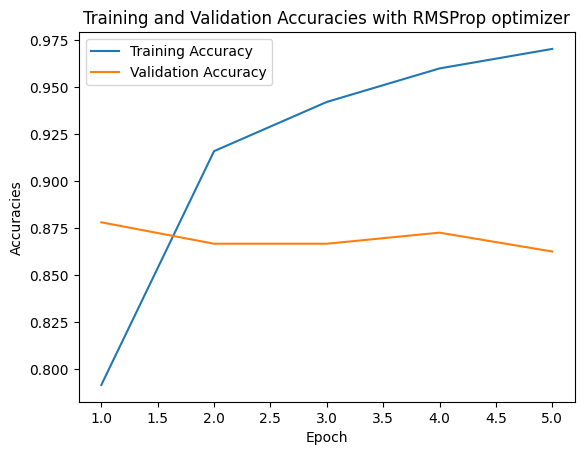

In [28]:
train_acc= rms_optim_LSTM['train_acc']
valid_acc = rms_optim_LSTM['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies with RMSProp optimizer')
plt.legend()
plt.show()

**Using Adam Optimizer**

In [24]:
adam_hyperparams = HyperParams()
adam_hyperparams.LR = 0.001
adam_hyperparams.OPTIM = "adam"
adam_optim_LSTM= train_and_test_model_with_hparams(adam_hyperparams, "lstm_1layer_base_adam_e32_h100")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 125,975 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 22.45it/s]
Saving ...
epoch: 1
train_loss: 0.510, train_acc: 0.705
valid_loss: 0.321, valid_acc: 0.872
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 22.17it/s]
epoch: 2
train_loss: 0.245, train_acc: 0.903
valid_loss: 0.343, valid_acc: 0.860
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 18.95it/s]
Saving ...
epoch: 3
train_loss: 0.164, train_acc: 0.940
valid_loss: 0.306, valid_acc: 0.881
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 14.68it/s]
epoch: 4
train_loss: 0.110, train_acc: 0.960
valid_loss: 0.358, valid_acc: 0.874
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.48it/s]
epoch: 5
train_loss: 0.075, train_acc: 0.975
valid_loss: 0.497, valid_acc: 0.859
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 21.07it/s]
test_loss: 0.294, test_acc

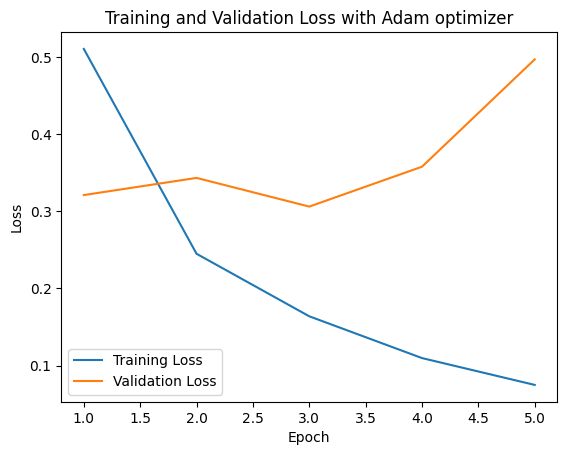

In [29]:
train_losses = adam_optim_LSTM['train_loss']
valid_losses = adam_optim_LSTM['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Adam optimizer')
plt.legend()
plt.show()

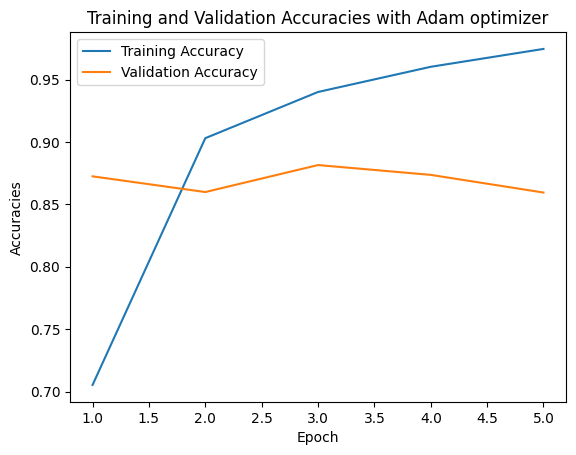

In [30]:
train_acc= adam_optim_LSTM['train_acc']
valid_acc = adam_optim_LSTM['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies with Adam optimizer')
plt.legend()
plt.show()

### Lab 2 (b): Study of GRU Optimizers. Hint: For adaptive optimizers, we recommend using a learning rate of 0.001 (instead of 0.01).

**Using Adagrad Optimizer**

In [31]:
adagrad_hyperparams = HyperParams()
adagrad_hyperparams.LR = 0.001
adagrad_hyperparams.OPTIM = "adagrad"
adagrad_optim_GRU= train_and_test_model_with_hparams(adagrad_hyperparams, "gru_1layer_base_adagrad_e32_h100", override_models_with_gru=True)

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 115,675 trainable parameters
Using adagrad
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.21it/s]
Saving ...
epoch: 1
train_loss: 0.671, train_acc: 0.563
valid_loss: 0.520, valid_acc: 0.750
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.80it/s]
Saving ...
epoch: 2
train_loss: 0.438, train_acc: 0.804
valid_loss: 0.409, valid_acc: 0.828
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.41it/s]
Saving ...
epoch: 3
train_loss: 0.359, train_acc: 0.850
valid_loss: 0.396, valid_acc: 0.831
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 15.88it/s]
Saving ...
epoch: 4
train_loss: 0.322, train_acc: 0.868
valid_loss: 0.352, valid_acc: 0.855
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.68it/s]
Saving ...
epoch: 5
train_loss: 0.295, train_acc: 0.881
valid_loss: 0.342, valid_acc: 0.861
evaluating...: 100%|██████████| 105/105 [00:

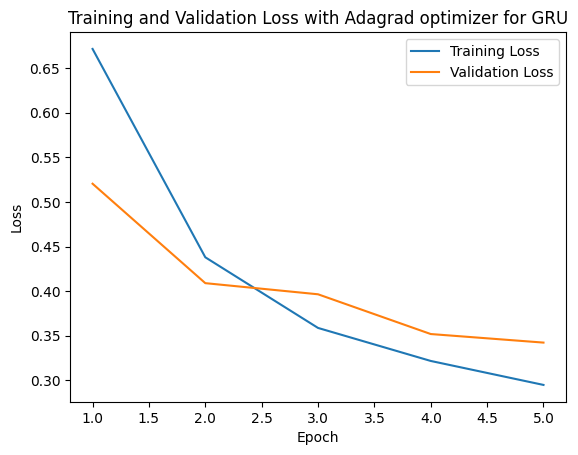

In [34]:
train_losses = adagrad_optim_GRU['train_loss']
valid_losses = adagrad_optim_GRU['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Adagrad optimizer for GRU')
plt.legend()
plt.show()

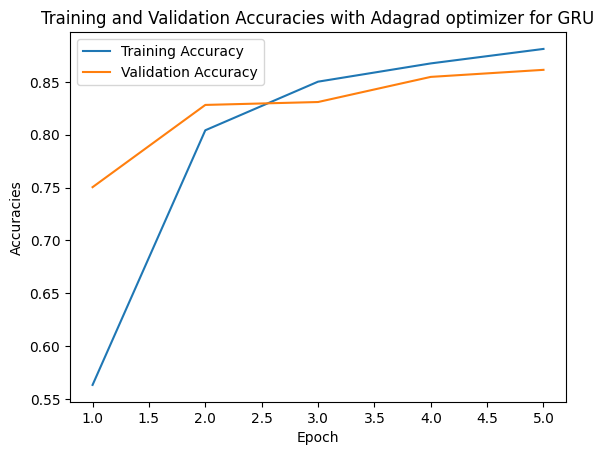

In [35]:
train_acc= adagrad_optim_GRU['train_acc']
valid_acc = adagrad_optim_GRU['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies with Adagrad optimizer for GRU')
plt.legend()
plt.show()

**Using RMSProp Optimizer**

In [32]:
rms_hyperparams = HyperParams()
rms_hyperparams.LR = 0.001
rms_hyperparams.OPTIM = "rmsprop"
rmsprop_optim_GRU= train_and_test_model_with_hparams(rms_hyperparams, "gru_1layer_base_rmsprop_e32_h100", override_models_with_gru=True)

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 115,675 trainable parameters
Using rmsprop
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.53it/s]
Saving ...
epoch: 1
train_loss: 0.410, train_acc: 0.797
valid_loss: 0.321, valid_acc: 0.868
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 22.24it/s]
epoch: 2
train_loss: 0.222, train_acc: 0.915
valid_loss: 0.360, valid_acc: 0.863
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 16.37it/s]
epoch: 3
train_loss: 0.148, train_acc: 0.944
valid_loss: 0.384, valid_acc: 0.867
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 15.99it/s]
epoch: 4
train_loss: 0.109, train_acc: 0.960
valid_loss: 0.449, valid_acc: 0.860
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.59it/s]
epoch: 5
train_loss: 0.087, train_acc: 0.968
valid_loss: 0.512, valid_acc: 0.863
evaluating...: 100%|██████████| 105/105 [00:04<00:00, 21.01it/s]
test_loss: 0.318, test_

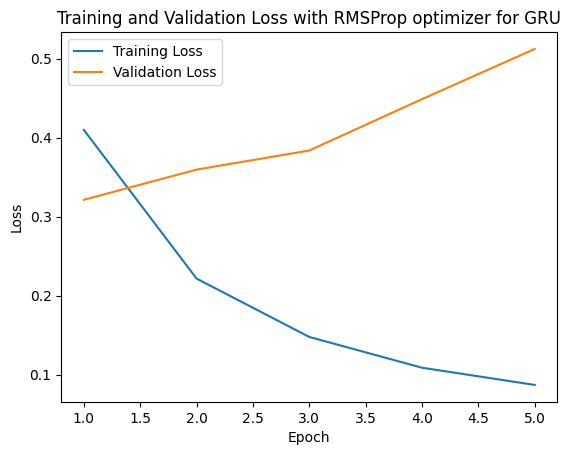

In [36]:
train_losses = rmsprop_optim_GRU['train_loss']
valid_losses = rmsprop_optim_GRU['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with RMSProp optimizer for GRU')
plt.legend()
plt.show()

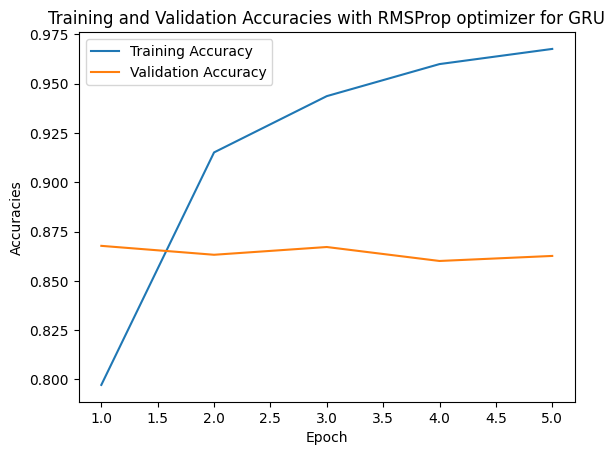

In [37]:
train_acc= rmsprop_optim_GRU['train_acc']
valid_acc = rmsprop_optim_GRU['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies with RMSProp optimizer for GRU')
plt.legend()
plt.show()

**Using Adam Optimizer**

In [33]:
adam_hyperparams = HyperParams()
adam_hyperparams.LR = 0.001
adam_hyperparams.OPTIM = "adam"
adam_optim_GRU= train_and_test_model_with_hparams(adam_hyperparams,"gru_1layer_base_adam_e32_h100", override_models_with_gru=True)

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 115,675 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.87it/s]
Saving ...
epoch: 1
train_loss: 0.527, train_acc: 0.703
valid_loss: 0.365, valid_acc: 0.844
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.86it/s]
Saving ...
epoch: 2
train_loss: 0.229, train_acc: 0.912
valid_loss: 0.302, valid_acc: 0.879
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 13.57it/s]
epoch: 3
train_loss: 0.148, train_acc: 0.946
valid_loss: 0.349, valid_acc: 0.872
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.83it/s]
epoch: 4
train_loss: 0.102, train_acc: 0.963
valid_loss: 0.387, valid_acc: 0.873
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.94it/s]
epoch: 5
train_loss: 0.070, train_acc: 0.975
valid_loss: 0.571, valid_acc: 0.868
evaluating...: 100%|██████████| 105/105 [00:05<00:00, 19.02it/s]
test_loss: 0.288, test_acc

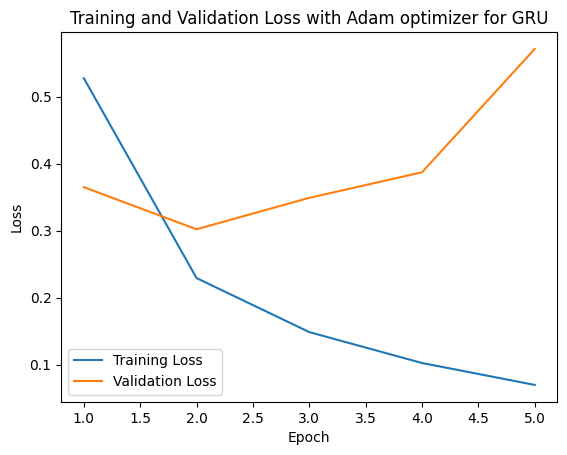

In [38]:
train_losses = adam_optim_GRU['train_loss']
valid_losses = adam_optim_GRU['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Adam optimizer for GRU')
plt.legend()
plt.show()

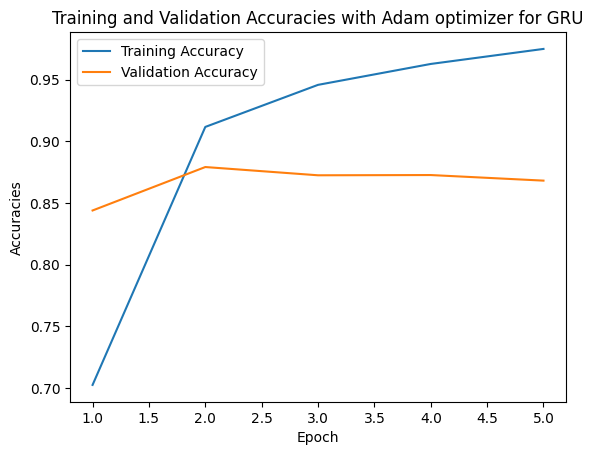

In [39]:
train_acc= adam_optim_GRU['train_acc']
valid_acc = adam_optim_GRU['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies with Adam optimizer for GRU')
plt.legend()
plt.show()

### Lab 2 (c) Deeper LSTMs

**Using LSTM with Adam Optimizer with 2 recurrent layers**

In [40]:
adam_hyperparams = HyperParams()
adam_hyperparams.LR = 0.001
adam_hyperparams.OPTIM = "adam"
adam_hyperparams.N_LAYERS=2
adam_optim_2_layers= train_and_test_model_with_hparams(adam_hyperparams, "lstm_1layer_base_adam_e32_h100_deep_2")



shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 206,775 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:04<00:00, 12.58it/s]
Saving ...
epoch: 1
train_loss: 0.568, train_acc: 0.652
valid_loss: 0.321, valid_acc: 0.869
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.81it/s]
Saving ...
epoch: 2
train_loss: 0.260, train_acc: 0.898
valid_loss: 0.281, valid_acc: 0.888
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.70it/s]
epoch: 3
train_loss: 0.175, train_acc: 0.935
valid_loss: 0.336, valid_acc: 0.882
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 17.54it/s]
epoch: 4
train_loss: 0.125, train_acc: 0.956
valid_loss: 0.364, valid_acc: 0.875
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.46it/s]
epoch: 5
train_loss: 0.089, train_acc: 0.968
valid_loss: 0.432, valid_acc: 0.868
evaluating...: 100%|██████████| 105/105 [00:06<00:00, 16.06it/s]
test_loss: 0.275, test_acc

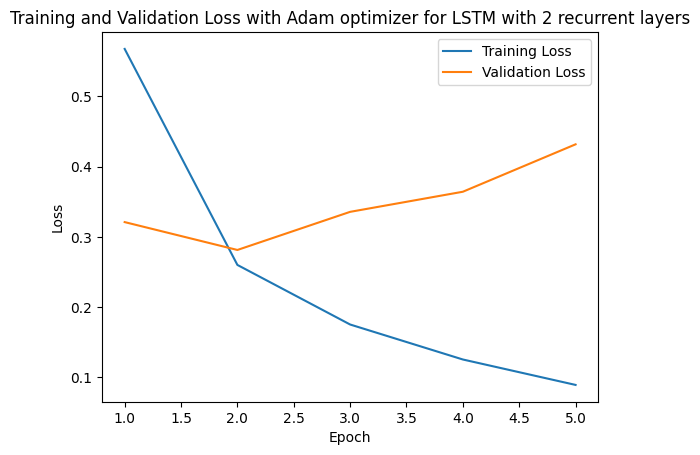

In [47]:
train_losses = adam_optim_2_layers['train_loss']
valid_losses = adam_optim_2_layers['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Adam optimizer for LSTM with 2 recurrent layers')
plt.legend()
plt.show()

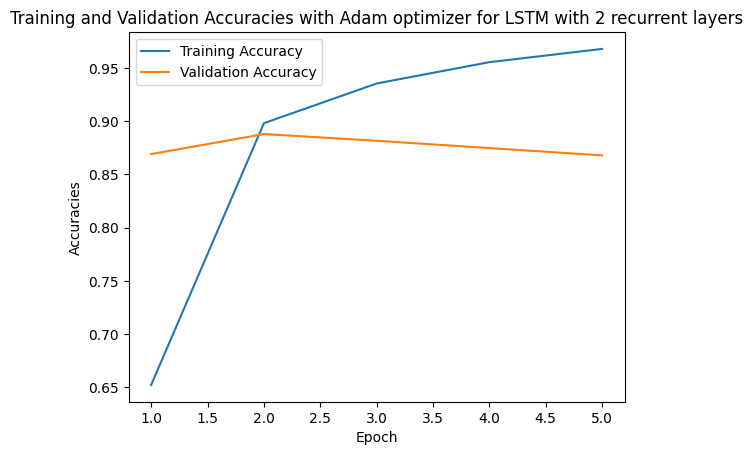

In [48]:
train_acc= adam_optim_2_layers['train_acc']
valid_acc = adam_optim_2_layers['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies with Adam optimizer for LSTM with 2 recurrent layers')
plt.legend()
plt.show()

**Using LSTM with the Adam Optimizer and 3 recurrent layers**

In [41]:
adam_hyperparams = HyperParams()
adam_hyperparams.LR = 0.001
adam_hyperparams.OPTIM = "adam"
adam_hyperparams.N_LAYERS=3
adam_optim_3_layers= train_and_test_model_with_hparams(adam_hyperparams, "lstm_1layer_base_adam_e32_h100_deep_3")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 287,575 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 15.68it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.518
valid_loss: 0.894, valid_acc: 0.506
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.37it/s]
Saving ...
epoch: 2
train_loss: 0.371, train_acc: 0.839
valid_loss: 0.300, valid_acc: 0.878
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.38it/s]
Saving ...
epoch: 3
train_loss: 0.225, train_acc: 0.912
valid_loss: 0.295, valid_acc: 0.886
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 15.09it/s]
epoch: 4
train_loss: 0.165, train_acc: 0.939
valid_loss: 0.389, valid_acc: 0.863
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.57it/s]
epoch: 5
train_loss: 0.125, train_acc: 0.954
valid_loss: 0.387, valid_acc: 0.874
evaluating...: 100%|██████████| 105/105 [00:06<00:00, 16.01it/s]
test_loss: 0.28

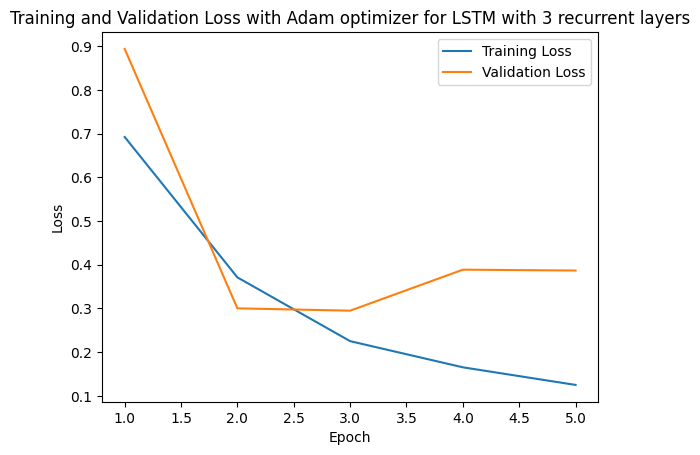

In [49]:
train_losses = adam_optim_3_layers['train_loss']
valid_losses = adam_optim_3_layers['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Adam optimizer for LSTM with 3 recurrent layers')
plt.legend()
plt.show()

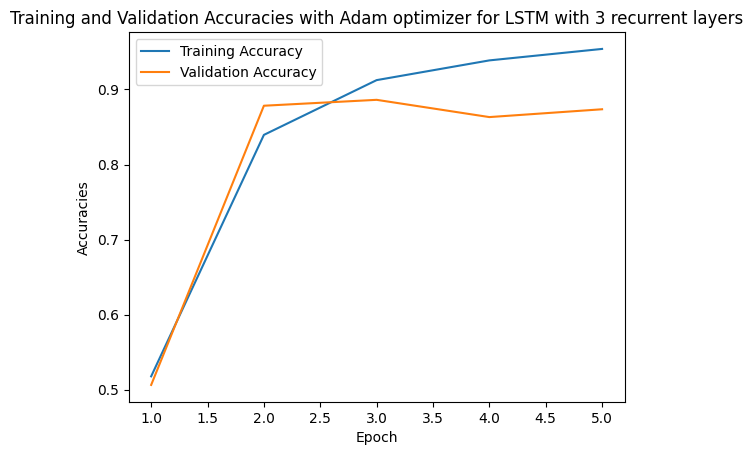

In [50]:
train_acc= adam_optim_3_layers['train_acc']
valid_acc = adam_optim_3_layers['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies with Adam optimizer for LSTM with 3 recurrent layers')
plt.legend()
plt.show()

**Using LSTM with the Adam Optimizer and 4 recurrent layers**

In [42]:
adam_hyperparams = HyperParams()
adam_hyperparams.LR = 0.001
adam_hyperparams.OPTIM = "adam"
adam_hyperparams.N_LAYERS=4
adam_optim_4_layers= train_and_test_model_with_hparams(adam_hyperparams, "lstm_1layer_base_adam_e32_h100_deep_4")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 368,375 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:04<00:00, 12.54it/s]
Saving ...
epoch: 1
train_loss: 0.694, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.511
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.07it/s]
Saving ...
epoch: 2
train_loss: 0.528, train_acc: 0.708
valid_loss: 0.355, valid_acc: 0.852
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.64it/s]
Saving ...
epoch: 3
train_loss: 0.257, train_acc: 0.898
valid_loss: 0.305, valid_acc: 0.883
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.09it/s]
epoch: 4
train_loss: 0.185, train_acc: 0.930
valid_loss: 0.313, valid_acc: 0.879
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 18.67it/s]
epoch: 5
train_loss: 0.135, train_acc: 0.950
valid_loss: 0.376, valid_acc: 0.883
evaluating...: 100%|██████████| 105/105 [00:06<00:00, 16.60it/s]
test_loss: 0.29

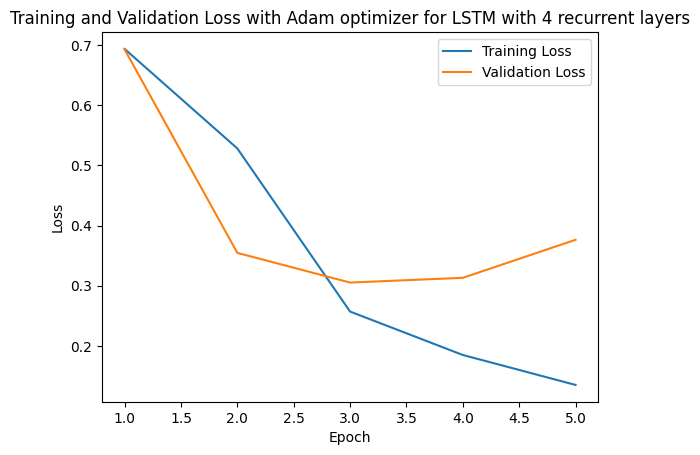

In [51]:
train_losses = adam_optim_4_layers['train_loss']
valid_losses = adam_optim_4_layers['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Adam optimizer for LSTM with 4 recurrent layers')
plt.legend()
plt.show()

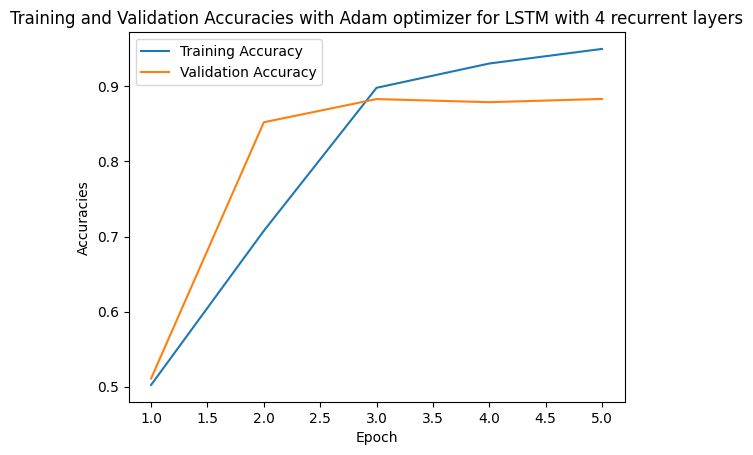

In [52]:
train_acc= adam_optim_4_layers['train_acc']
valid_acc = adam_optim_4_layers['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies with Adam optimizer for LSTM with 4 recurrent layers')
plt.legend()
plt.show()

### Lab 2 (d) Wider LSTMs

In [43]:
adam_hyperparams = HyperParams()
adam_hyperparams.LR = 0.001
adam_hyperparams.OPTIM = "adam"
adam_hyperparams.HIDDEN_DIM = 150
adam_optim_150_hidden= train_and_test_model_with_hparams(adam_hyperparams, "lstm_1layer_base_adam_e32_h150")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 202,175 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 18.70it/s]
Saving ...
epoch: 1
train_loss: 0.529, train_acc: 0.688
valid_loss: 0.316, valid_acc: 0.874
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.94it/s]
Saving ...
epoch: 2
train_loss: 0.244, train_acc: 0.904
valid_loss: 0.275, valid_acc: 0.887
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 16.35it/s]
epoch: 3
train_loss: 0.167, train_acc: 0.938
valid_loss: 0.302, valid_acc: 0.887
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.10it/s]
epoch: 4
train_loss: 0.116, train_acc: 0.958
valid_loss: 0.340, valid_acc: 0.881
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 22.43it/s]
epoch: 5
train_loss: 0.079, train_acc: 0.972
valid_loss: 0.431, valid_acc: 0.875
evaluating...: 100%|██████████| 105/105 [00:06<00:00, 15.73it/s]
test_loss: 0.271, test_acc

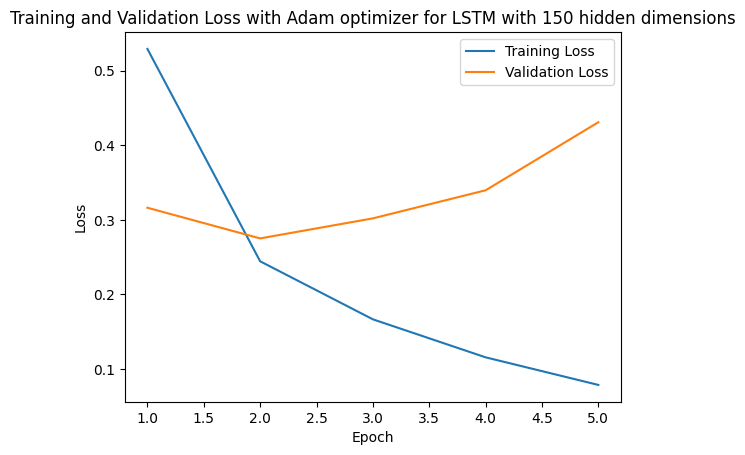

In [53]:
train_losses = adam_optim_150_hidden['train_loss']
valid_losses = adam_optim_150_hidden['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Adam optimizer for LSTM with 150 hidden dimensions')
plt.legend()
plt.show()

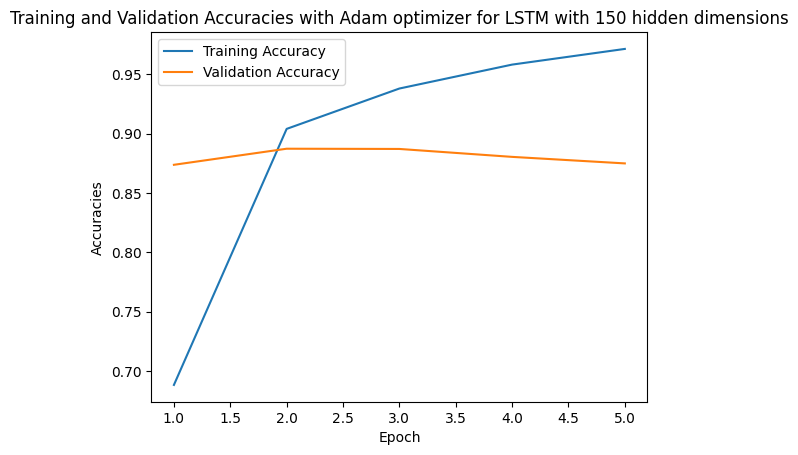

In [54]:
train_acc= adam_optim_150_hidden['train_acc']
valid_acc = adam_optim_150_hidden['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies with Adam optimizer for LSTM with 150 hidden dimensions')
plt.legend()
plt.show()

In [44]:
adam_hyperparams = HyperParams()
adam_hyperparams.LR = 0.001
adam_hyperparams.OPTIM = "adam"
adam_hyperparams.HIDDEN_DIM = 220
adam_optim_220_hidden= train_and_test_model_with_hparams(adam_hyperparams, "lstm_1layer_base_adam_e32_h220")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 342,455 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 17.98it/s]
Saving ...
epoch: 1
train_loss: 0.506, train_acc: 0.708
valid_loss: 0.296, valid_acc: 0.883
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 16.44it/s]
Saving ...
epoch: 2
train_loss: 0.232, train_acc: 0.910
valid_loss: 0.279, valid_acc: 0.890
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.03it/s]
epoch: 3
train_loss: 0.160, train_acc: 0.940
valid_loss: 0.299, valid_acc: 0.880
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.43it/s]
epoch: 4
train_loss: 0.107, train_acc: 0.961
valid_loss: 0.369, valid_acc: 0.875
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 15.98it/s]
epoch: 5
train_loss: 0.075, train_acc: 0.973
valid_loss: 0.521, valid_acc: 0.856
evaluating...: 100%|██████████| 105/105 [00:06<00:00, 16.08it/s]
test_loss: 0.273, test_acc

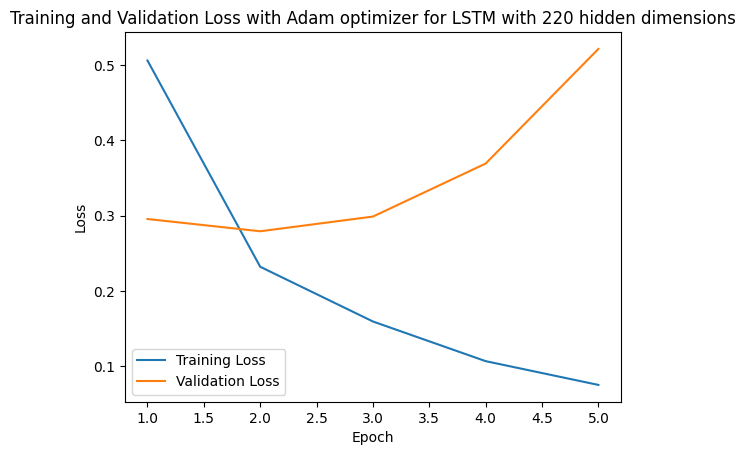

In [55]:
train_losses = adam_optim_220_hidden['train_loss']
valid_losses = adam_optim_220_hidden['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Adam optimizer for LSTM with 220 hidden dimensions')
plt.legend()
plt.show()

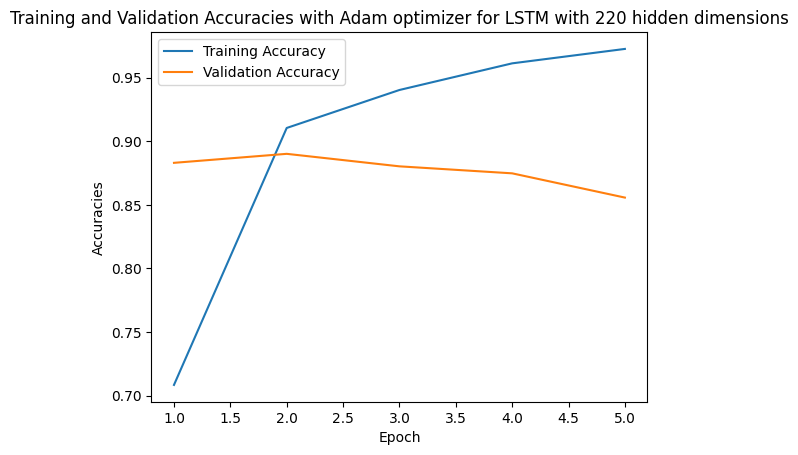

In [56]:
train_acc= adam_optim_220_hidden['train_acc']
valid_acc = adam_optim_220_hidden['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies with Adam optimizer for LSTM with 220 hidden dimensions')
plt.legend()
plt.show()

In [45]:
adam_hyperparams = HyperParams()
adam_hyperparams.LR = 0.001
adam_hyperparams.OPTIM = "adam"
adam_hyperparams.HIDDEN_DIM = 320
adam_optim_320_hidden= train_and_test_model_with_hparams(adam_hyperparams, "lstm_1layer_base_adam_e32_h150")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 610,855 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.90it/s]
Saving ...
epoch: 1
train_loss: 0.542, train_acc: 0.673
valid_loss: 0.323, valid_acc: 0.871
evaluating...: 100%|██████████| 53/53 [00:04<00:00, 12.06it/s]
Saving ...
epoch: 2
train_loss: 0.247, train_acc: 0.903
valid_loss: 0.278, valid_acc: 0.885
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.17it/s]
epoch: 3
train_loss: 0.167, train_acc: 0.938
valid_loss: 0.299, valid_acc: 0.881
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.04it/s]
epoch: 4
train_loss: 0.117, train_acc: 0.957
valid_loss: 0.372, valid_acc: 0.874
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.99it/s]
epoch: 5
train_loss: 0.079, train_acc: 0.972
valid_loss: 0.478, valid_acc: 0.869
evaluating...: 100%|██████████| 105/105 [00:07<00:00, 13.78it/s]
test_loss: 0.271, test_acc

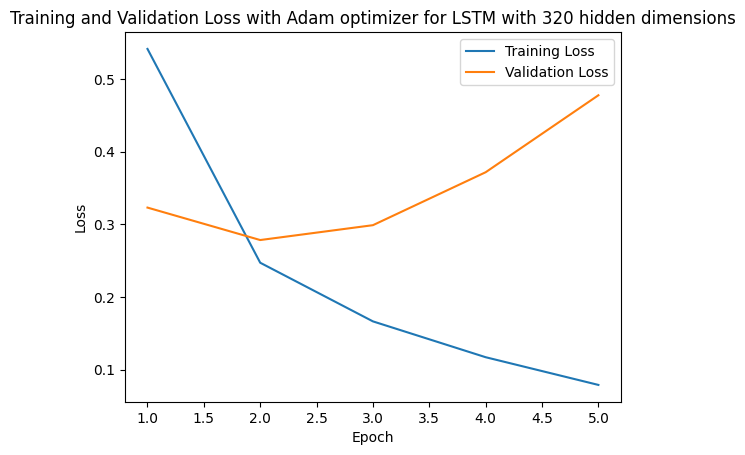

In [57]:
train_losses = adam_optim_320_hidden['train_loss']
valid_losses = adam_optim_320_hidden['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Adam optimizer for LSTM with 320 hidden dimensions')
plt.legend()
plt.show()

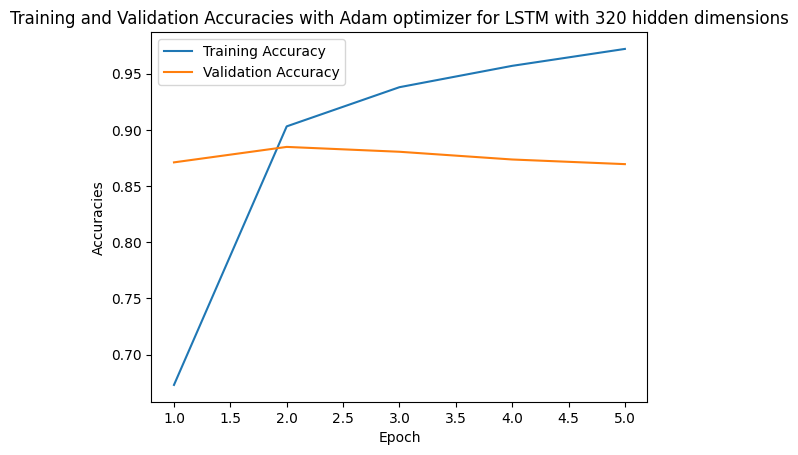

In [58]:
train_acc= adam_optim_320_hidden['train_acc']
valid_acc = adam_optim_320_hidden['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies with Adam optimizer for LSTM with 320 hidden dimensions')
plt.legend()
plt.show()

### Lab 2 (e) Larger Embedding Table

In [62]:
adam_hyperparams = HyperParams()
adam_hyperparams.LR = 0.001
adam_hyperparams.OPTIM = "adam"
adam_hyperparams.EMBEDDING_DIM = 150
adam_optim_embed= train_and_test_model_with_hparams(adam_hyperparams, "lstm_1layer_base_adam_e32_embed")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 5,187,952 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.94it/s]
Saving ...
epoch: 1
train_loss: 0.425, train_acc: 0.774
valid_loss: 0.328, valid_acc: 0.866
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.88it/s]
Saving ...
epoch: 2
train_loss: 0.195, train_acc: 0.927
valid_loss: 0.314, valid_acc: 0.875
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 15.29it/s]
epoch: 3
train_loss: 0.097, train_acc: 0.966
valid_loss: 0.416, valid_acc: 0.863
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 21.58it/s]
epoch: 4
train_loss: 0.028, train_acc: 0.991
valid_loss: 0.611, valid_acc: 0.866
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 22.43it/s]
epoch: 5
train_loss: 0.011, train_acc: 0.996
valid_loss: 0.790, valid_acc: 0.869
evaluating...: 100%|██████████| 105/105 [00:05<00:00, 19.77it/s]
test_loss: 0.307, test_a

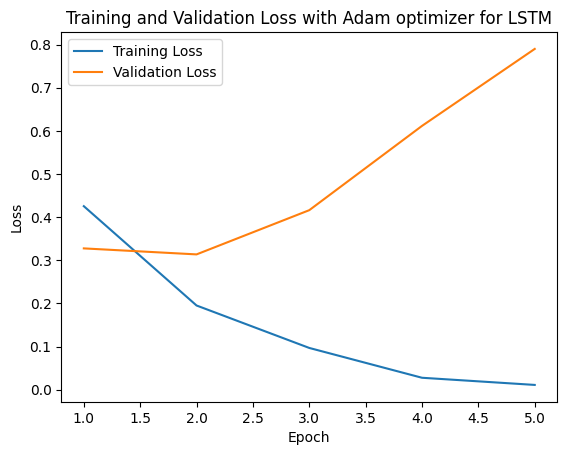

In [63]:
train_losses = adam_optim_embed['train_loss']
valid_losses = adam_optim_embed['valid_loss']

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Adam optimizer for LSTM')
plt.legend()
plt.show()

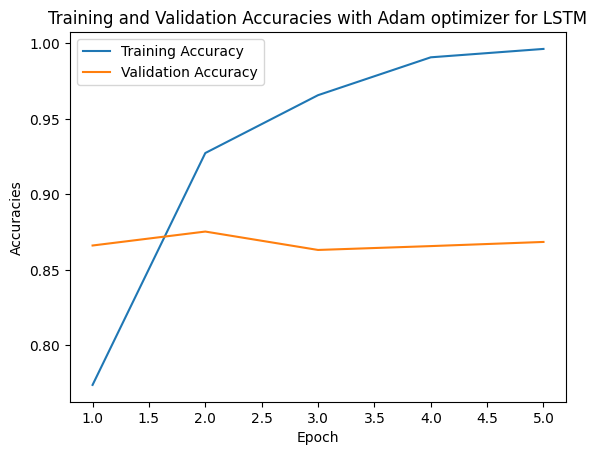

In [64]:
train_acc= adam_optim_embed['train_acc']
valid_acc = adam_optim_embed['valid_acc']

epochs = list(range(1, len(train_acc) + 1))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracies with Adam optimizer for LSTM')
plt.legend()
plt.show()

### Lab 2(f) Compound scaling of embedding_dim, hidden_dim, layers

In [65]:
adam_hyperparams = HyperParams()
adam_hyperparams.LR = 0.001
adam_hyperparams.OPTIM = "adam"
adam_hyperparams.HIDDEN_DIM = 150
adam_hyperparams.N_LAYERS=2
adam_hyperparams.EMBEDDING_DIM = 150
adam_optim_comp= train_and_test_model_with_hparams(adam_hyperparams, "lstm_1layer_base_adam_comp")

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 33573
The model has 5,475,152 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:04<00:00, 13.18it/s]
Saving ...
epoch: 1
train_loss: 0.424, train_acc: 0.781
valid_loss: 0.303, valid_acc: 0.876
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 20.05it/s]
epoch: 2
train_loss: 0.202, train_acc: 0.923
valid_loss: 0.311, valid_acc: 0.875
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 18.97it/s]
epoch: 3
train_loss: 0.122, train_acc: 0.956
valid_loss: 0.392, valid_acc: 0.871
evaluating...: 100%|██████████| 53/53 [00:03<00:00, 14.17it/s]
epoch: 4
train_loss: 0.080, train_acc: 0.971
valid_loss: 0.420, valid_acc: 0.872
evaluating...: 100%|██████████| 53/53 [00:02<00:00, 19.19it/s]
epoch: 5
train_loss: 0.051, train_acc: 0.981
valid_loss: 0.625, valid_acc: 0.873
evaluating...: 100%|██████████| 105/105 [00:07<00:00, 14.12it/s]
test_loss: 0.303, test_acc: 0.875


### Lab 2 (g) Bi-Directional LSTM, using best architecture from (f)